In [6]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import copy
import time
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
data=pd.read_csv('mnist_train.csv')
idx=np.random.choice(data.index,6000)
data=data.iloc[idx]
data.reset_index(inplace=True)
data.drop(columns='index',inplace=True)
labels=data.iloc[:,0]
data=data.iloc[:, 1:]
dataNorm=data/np.max(data,axis=0)
dataNorm.fillna(0,inplace=True)




In [3]:
dataT=torch.tensor(np.array(dataNorm)).float()
labelsT=torch.tensor(np.array(labels)).long()
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
     

In [5]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (using SGD to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [14]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 60
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []
  weightChange=np.zeros((numepochs,4))
  weightConds=np.zeros((numepochs,4))
  


  # loop over epochs
  for epochi in range(numepochs):
    preW=[]
    for p in net.named_parameters():
      if 'weight' in p[0]:
        preW.append(copy.deepcopy(p[1].data.numpy()))
        





    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
    
    # finally, get the post-learning state of the weights
    for (i,p) in enumerate(net.named_parameters()):
      if 'weight' in p[0]:
        # condition number
        weightConds[epochi,int(i/2)]  = np.linalg.cond(p[1].data)

        # Frobenius norm of the weight change from pre-learning
        weightChange[epochi,int(i/2)] = np.linalg.norm( preW[int(i/2)]-p[1].data.numpy(), ord='fro')

    
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,weightChange,weightConds,preW
     

In [15]:
# create the network
net,lossfun,optimizer = createTheMNISTNet()

for i,p in enumerate(net.named_parameters()):
  print(i,p)
  

0 ('input.weight', Parameter containing:
tensor([[-3.3524e-02,  1.0440e-02,  1.6527e-02,  ..., -1.9161e-02,
          3.7253e-05,  2.4357e-02],
        [ 2.3538e-02, -2.6507e-02, -8.4054e-03,  ..., -1.7915e-02,
         -3.2741e-02, -1.2211e-03],
        [-2.4453e-03, -1.0057e-03,  1.4304e-04,  ..., -3.0206e-02,
         -2.2845e-02, -1.2841e-02],
        ...,
        [ 8.2276e-03,  2.7089e-02, -2.4831e-02,  ...,  3.1323e-02,
          2.4233e-02,  2.2956e-02],
        [ 1.9999e-02, -4.3551e-03,  2.5831e-03,  ...,  1.7387e-02,
          1.5178e-03,  3.0742e-02],
        [ 3.4020e-02, -2.6088e-02, -2.3318e-02,  ...,  1.2630e-02,
          1.2943e-02,  1.3983e-02]], requires_grad=True))
1 ('input.bias', Parameter containing:
tensor([-0.0311, -0.0213, -0.0348,  0.0185,  0.0304,  0.0087,  0.0330,  0.0009,
        -0.0062,  0.0085,  0.0351, -0.0191, -0.0067, -0.0176, -0.0053, -0.0289,
         0.0153,  0.0220,  0.0174, -0.0182, -0.0012, -0.0025, -0.0025,  0.0039,
         0.0035,  0.0078,  

In [16]:
trainAcc,testAcc,losses,net,weightChange,weightConds,preW = function2trainTheModel(net,lossfun,optimizer)
     

In [23]:
p= next(iter(net.named_parameters()))
if 'weight' in p[0]:
        # condition number
        print(np.linalg.cond(p[1].data))
        print(np.linalg.norm( preW[0]-p[1].data.numpy(), ord='fro'))



2.0812685
0.03299671


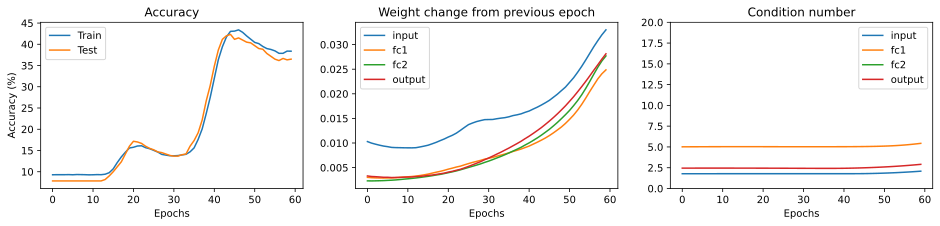

In [24]:
# Show the results!

# get a list of layer names
layername = []
for (i,p) in enumerate(net.named_parameters()):
  if 'weight' in p[0]:
    layername.append(p[0][:-7])


# set up the plot
fig,ax = plt.subplots(1,3,figsize=(16,3))

# accuracy
ax[0].plot(trainAcc)
ax[0].plot(testAcc)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Accuracy')
ax[0].legend(['Train','Test'])

# weight changes
ax[1].plot(weightChange)
ax[1].set_xlabel('Epochs')
ax[1].set_title('Weight change from previous epoch')
ax[1].legend(layername)

# weight condition numbers
ax[2].plot(weightConds)
ax[2].set_xlabel('Epochs')
ax[2].set_title('Condition number')
ax[2].legend(layername)
ax[2].set_ylim([0,20])

plt.show()

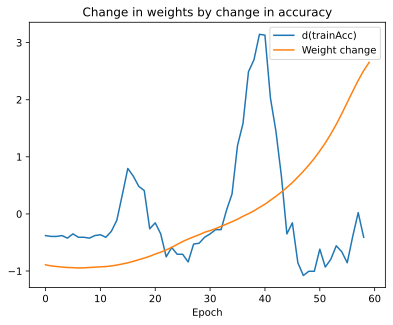

In [25]:

# final inspection: check the derivative of accuracy against the weight change
from scipy.stats import zscore # normalize for scaling offsets

plt.plot(zscore(np.diff(trainAcc)),label='d(trainAcc)')
plt.plot(zscore(np.mean(weightChange,axis=1)),label='Weight change')
plt.legend()
plt.title('Change in weights by change in accuracy')
plt.xlabel('Epoch')
plt.show()
     